<a href="https://colab.research.google.com/github/yj0905/2020/blob/master/lesson7_resnet_mnist_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pycharm에서 원격 연결 하고 디버깅을 하려 했지만 계속 error가 발생해 디버깅이 불가하여 colab으로 실행을 하고 제출합니다.

원격 연결은 잘 되지만 debugging이 되질 않습니다...

## MNIST CNN

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

### Data

In [0]:
path = untar_data(URLs.MNIST) #mnist dataset download

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/mnist_png/testing'),
 PosixPath('/root/.fastai/data/mnist_png/training')]

In [0]:
il = ImageList.from_folder(path, convert_mode='L') #이미지 변환해서 이미지 리스트 만들기

In [0]:
il.items[0]

PosixPath('/root/.fastai/data/mnist_png/testing/9/4363.png')

In [0]:
defaults.cmap='binary'

In [0]:
il #총 70000개 이미지

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png

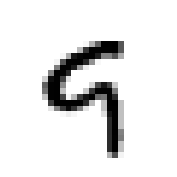

In [0]:
il[0].show()

In [0]:
sd = il.split_by_folder(train='training', valid='testing')

In [0]:
sd #60000개 이미지는 train, 10000개는 valid에 사용

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Test: None

In [0]:
(path/'training').ls()

[PosixPath('/root/.fastai/data/mnist_png/training/9'),
 PosixPath('/root/.fastai/data/mnist_png/training/7'),
 PosixPath('/root/.fastai/data/mnist_png/training/1'),
 PosixPath('/root/.fastai/data/mnist_png/training/2'),
 PosixPath('/root/.fastai/data/mnist_png/training/0'),
 PosixPath('/root/.fastai/data/mnist_png/training/6'),
 PosixPath('/root/.fastai/data/mnist_png/training/3'),
 PosixPath('/root/.fastai/data/mnist_png/training/8'),
 PosixPath('/root/.fastai/data/mnist_png/training/5'),
 PosixPath('/root/.fastai/data/mnist_png/training/4')]

In [0]:
ll = sd.label_from_folder() #라벨링

In [0]:
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
9,9,9,9,9
Path: /root/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
9,9,9,9,9
Path: /root/.fastai/data/mnist_png;

Test: None

In [0]:
x,y = ll.train[0] #첫번째 데이터(9)

9 torch.Size([1, 28, 28])


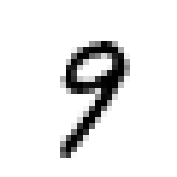

In [0]:
x.show()
print(y,x.shape)

In [0]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], []) #랜덤으로 padding 설정

In [0]:
ll = ll.transform(tfms)

In [0]:
bs = 128

In [0]:
# not using imagenet_stats because not using pretrained model
data = ll.databunch(bs=bs).normalize()

In [0]:
x,y = data.train_ds[0]

9


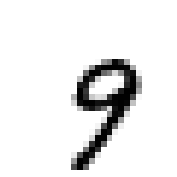

In [0]:
x.show()
print(y) #이미지 안쪽에 여백(padding)이 생김

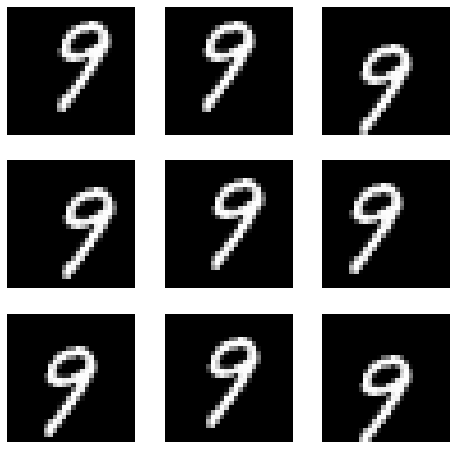

In [0]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

In [0]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

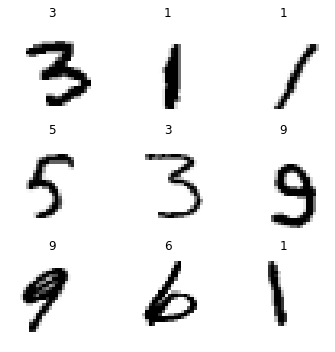

In [0]:
data.show_batch(rows=3, figsize=(5,5))

### Basic CNN with batchnorm

In [0]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
# 커널 크기:3*3, 스텝 사이즈:2, 패딩:1로 convolution

In [0]:
model = nn.Sequential(
    conv(1, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [0]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

In [0]:
xb = xb.cuda()

In [0]:
model(xb).shape

torch.Size([128, 10])

In [0]:
learn.lr_find(end_lr=100)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


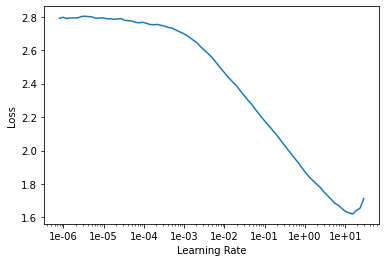

In [0]:
learn.recorder.plot() #learning rate

In [0]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.223496,0.167811,0.946100,00:25
1,0.129525,0.074083,0.976500,00:25
2,0.074016,0.041607,0.986900,00:26


### Refactor

In [0]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)
#합성곱 계층으로 conv2d() 함수에 정의된 선형 합성곱에 편향값을 더한 후 비선형 함수인 ReLU를 적용한다.

In [0]:
https://excelsior-cjh.tistory.com/152 참고함

In [0]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [0]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.224012,0.131044,0.960600,00:25
1,0.187147,0.110565,0.966500,00:25
2,0.156085,0.185739,0.939700,00:25
3,0.140686,0.085952,0.970600,00:25
4,0.126176,0.070901,0.978400,00:25
5,0.099505,0.084232,0.974000,00:25
6,0.083509,0.043519,0.986200,00:25
7,0.066363,0.039338,0.987600,00:26
8,0.049479,0.029587,0.990800,00:25
9,0.048020,0.028077,0.991400,00:26


### Resnet-ish

In [0]:
class ResBlock(nn.Module): #ResBlock: 레이어 2개 생성해서 더 깊은 학습 가능하도록
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [0]:
help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense:bool=False, norm_type:Union[fastai.layers.NormType, NoneType]=<NormType.Batch: 1>, bottle:bool=False, **conv_kwargs)
    Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`.



In [0]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [0]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [0]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


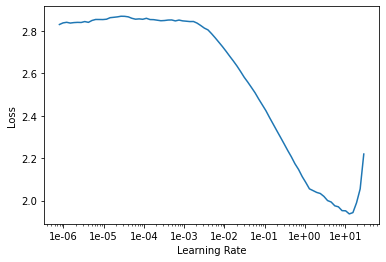

In [0]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.202129,0.168075,0.949000,00:28
1,0.123027,0.105622,0.965400,00:29
2,0.107858,0.095205,0.970200,00:29
3,0.087061,0.058122,0.982500,00:29
4,0.068673,0.049204,0.984600,00:29
5,0.060618,0.039772,0.987100,00:29
6,0.053963,0.078817,0.974400,00:28
7,0.048042,0.037139,0.987900,00:29
8,0.034496,0.024279,0.992500,00:29
9,0.029513,0.018167,0.993600,00:28


In [0]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
___________________________________________________

## fin